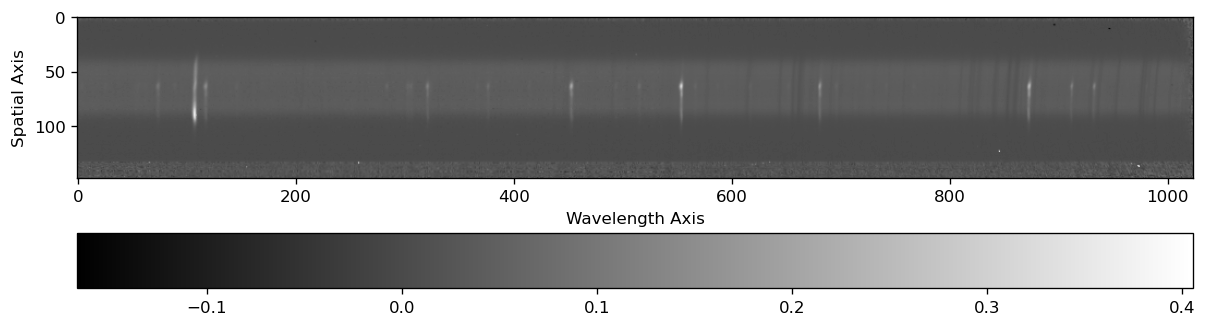

In [246]:
# import packages
from matplotlib import rcParams
rcParams['figure.dpi'] = 120
rcParams["savefig.dpi"] = 120
rcParams['figure.facecolor'] = 'w'

from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import os
from lmfit import Model

import warnings
warnings.filterwarnings('ignore')

# path joining version for other paths
notebook_path = os.path.abspath('h3p.ipynb')
filepath = os.path.join(os.path.dirname(notebook_path), '02jun17/spec/')

# count number of fits files in folder
filesize = len([name for name in os.listdir(filepath) if os.path.isfile(os.path.join(filepath, name))])

# load fits data
nirspec7_data = []

start_nirspec7 = 22 # fits index start, min >= 1, max <= n
end_nirspec7 = 112 # fits index end, min >= n, max <= 999

# order36
for i in range(filesize):
    n = i + start_nirspec7
    if n>= start_nirspec7 and n < 10:
        hdu_data = fits.getdata(filepath + 'order36/' + 'jun02s000' + '{}_order36.fits'.format(n), ext=0)
        nirspec7_data.append(hdu_data)
    elif n>= 10 and n < 100:
        hdu_data = fits.getdata(filepath + 'order36/' + 'jun02s00' + '{}_order36.fits'.format(n), ext=0)
        nirspec7_data.append(hdu_data)
    elif n >= 100 and n < end_nirspec7: # fits index ends at 111
        hdu_data = fits.getdata(filepath + 'order36/' + 'jun02s0' + '{}_order36.fits'.format(n), ext=0)
        nirspec7_data.append(hdu_data)
    elif n >= end_nirspec7:
        break
nirspec7_data_array = np.array(nirspec7_data)

# load waverange
waverange = fits.open(filepath + 'order36/' + 'waverange.fits', ignore_missing_end=True)[0].data

# obtain average flat field
average_flat_field = np.mean((nirspec7_data_array[32-start_nirspec7], 
                              nirspec7_data_array[33-start_nirspec7], 
                              nirspec7_data_array[34-start_nirspec7], 
                              nirspec7_data_array[35-start_nirspec7], 
                              nirspec7_data_array[36-start_nirspec7], 
                              nirspec7_data_array[37-start_nirspec7], 
                              nirspec7_data_array[38-start_nirspec7], 
                              nirspec7_data_array[39-start_nirspec7], 
                              nirspec7_data_array[40-start_nirspec7], 
                              nirspec7_data_array[41-start_nirspec7],), axis=0)


# obtain average flat lamp off
average_flat_lamp_off = np.mean((nirspec7_data_array[22-start_nirspec7], 
                                 nirspec7_data_array[23-start_nirspec7], 
                                 nirspec7_data_array[24-start_nirspec7],
                                 nirspec7_data_array[25-start_nirspec7], 
                                 nirspec7_data_array[26-start_nirspec7], 
                                 nirspec7_data_array[27-start_nirspec7], 
                                 nirspec7_data_array[28-start_nirspec7], 
                                 nirspec7_data_array[29-start_nirspec7], 
                                 nirspec7_data_array[30-start_nirspec7], 
                                 nirspec7_data_array[31-start_nirspec7],), axis=0)

# convert observation time (UTC) to seconds 
def fits_header_utc_to_second(fn):
    # fn = frame_number
    if fn >= start_nirspec7 and fn < 10:
        hdu_header = fits.open(filepath + 'jun02s000' + '{}.fits'.format(fn), ignore_missing_end=True)[0].header
    elif fn >= 10 and fn < 100:
        hdu_header = fits.open(filepath + 'jun02s00' + '{}.fits'.format(fn), ignore_missing_end=True)[0].header
    elif fn >= 100 and fn < end_nirspec7:
        hdu_header = fits.open(filepath + 'jun02s0' + '{}.fits'.format(fn), ignore_missing_end=True)[0].header
    elif fn >= end_nirspec7:
        pass
    
    h = float(hdu_header['UTC'].split(':')[0])
    m = float(hdu_header['UTC'].split(':')[1])
    s = float(hdu_header['UTC'].split(':')[2])
    
    seconds = h * 3600 + m * 60 + s
    return seconds

# scale the sky frame using the equation on page 9 of Stallard_et_al_2019
def scale_sky_frame(fn_spec):
    """
    confirmed sky frames: 51, 59, 60, 72, 78, 79, 91, 103
    """
    if fn_spec > 51 and fn_spec < 59:
        fn_sky1 = 51 # frame number of sky1
        fn_sky2 = 59 # frame number of sky2
    elif fn_spec > 60 and fn_spec < 72:
        fn_sky1 = 60
        fn_sky2 = 72
    elif fn_spec > 72 and fn_spec < 78:
        fn_sky1 = 72
        fn_sky2 = 78
    elif fn_spec > 78 and fn_spec < 91:
        fn_sky1 = 79
        fn_sky2 = 91
    elif fn_spec > 91 and fn_spec < 103:
        fn_sky1 = 91
        fn_sky2 = 103

    sky1 = nirspec7_data_array[fn_sky1-start_nirspec7]
    sky2 = nirspec7_data_array[fn_sky2-start_nirspec7]

    t1 = fits_header_utc_to_second(fn_sky1) 
    t2 = fits_header_utc_to_second(fn_sky2)
    td = fits_header_utc_to_second(fn_spec)

    sky_final = sky1 * ((t2 - td) / (t2 - t1)) + sky2 * ((td - t1) / (t2 - t1))
    return sky_final

fn_spec = 61 # frame number of target spectra
sky_total = scale_sky_frame(fn_spec)

# remove sky background: (object - sky_frame)/(average_flat_field - average_flat_lamp_off)
sky_subtracted = (nirspec7_data_array[fn_spec-start_nirspec7] - sky_total) / (average_flat_field - average_flat_lamp_off)
#sky_subtracted[sky_subtracted>0.2] = 0.2
pixel = np.linspace(0, np.size(sky_subtracted, 1), np.size(sky_subtracted, 1))

# show reduced fits
plt.figure(figsize=(12,6))
plt.imshow(sky_subtracted, cmap='gist_gray')
plt.xlabel('Wavelength Axis')
plt.ylabel('Spatial Axis')
#plt.gca().invert_yaxis()
#plt.xlim(500,600)
#plt.ylim(100,1)
plt.colorbar(orientation='horizontal', pad=0.1)

In [267]:
sky_subtracted.shape

(148, 1024)

In [11]:
# define normalization function
def normalize(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

# define guassian function, credit to pen and pants IDL's Gaussfit in Python
def gaussian_fit(x, a0, a1, a2, a3, a4, a5): 
    """
    x = data array
    a0 = height of guassian
    a1 = pixel position of Gaussian peak
    a2 = width of Gaussian
    a3 = constant term
    a4 = linear term
    a5 = quadratic term
    
    note: fwhm = a2 * np.sqrt(2 * np.log(2)) * 2
    """
    z = (x - a1) / a2
    y = a0 * np.exp(-z**2 / a2) + a3 + a4 * x + a5 * x**2
    return y

# create lmfit model with defined gaussian
h2_model = Model(gaussian_fit)
#print('parameter names: {}'.format(h2_model.param_names))
#print('independent variables: {}'.format(h2_model.independent_vars))


# create parameters and add initial guess
h2_params = h2_model.make_params()
h2_params.add('a0', value=0.2)
h2_params.add('a1', value=107)
h2_params.add('a2', value=1)
h2_params.add('a3', value=0)
h2_params.add('a4', value=0)
h2_params.add('a5', value=0)

# create h2 lists for all slits
h2_a0 = []
h2_a0_error = []
h2_a1 = []
h2_a1_error = []
h2_a2 = []
h2_a2_error = []


# loop over all slits containing observed emission 
# and obtain fitting parameters of each slit
lower_h2 = 5
upper_h2 = 140

In [46]:
sky_subtracted

array([[ 0.0412293 ,  0.03398116,  0.02437758, ..., -0.00147971,
         0.00423006, -0.05829752],
       [ 0.02796024,  0.03874303,  0.03699014, ...,  0.0178665 ,
         0.0014692 , -0.04244129],
       [ 0.03336291,  0.0734992 ,  0.02311317, ...,  0.04208162,
         0.02975182,  0.00786575],
       ...,
       [ 0.013971  ,  0.03542302,  0.0065843 , ...,  0.04080936,
         0.05168454,  0.01729839],
       [ 0.04549627,  0.0478504 ,  0.01144807, ...,  0.05578806,
         0.0020069 ,  0.09982322],
       [ 0.03972013,  0.01614752,  0.0149974 , ..., -0.00357379,
         0.00980686,  0.04083128]], dtype=float32)

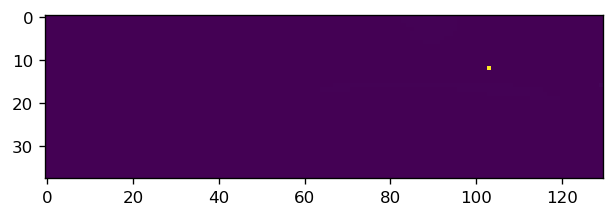

In [290]:
start_kband_north = 60
end_kband_north = 103
sky_frame = (51, 59, 60, 72, 78, 79, 91, 103)

h2_a0_map = []
for i in range(start_kband_north+1, end_kband_north):
    if i in sky_frame:
        continue
    skyfinal = scale_sky_frame(i)
    sky_subtract = (nirspec7_data_array[i-start_nirspec7] - skyfinal) / (average_flat_field - average_flat_lamp_off)
    #plt.figure()
    #plt.imshow(sky_subtract, cmap='gist_gray')
    #plt.title('frame number ' + str(i))

    # loop over all slits containing observed emission 
    # and obtain fitting parameters of each slit
    lower_h2 = 10
    upper_h2 = 140
    
    # create h2 lists for all slits
    h2_a0 = np.zeros(upper_h2-lower_h2)
    h2_a0_error = np.zeros(upper_h2-lower_h2)
    h2_a1 = []
    h2_a1_error = []
    h2_a2 = []
    h2_a2_error = []
    
    for j in range(lower_h2, upper_h2):
        try:
            h2_fit_result = h2_model.fit(sky_subtract[j], h2_params, x=pixel)
            h2_a0[j] = h2_fit_result.params['a0'].value
            #h2_a0_error.append(h2_fit_result.params['a0'].stderr)
        except:
            pass
    #h2_a0 = [0 if n < 0 else n for n in h2_a0]
    #h2_a0_array = np.array(h2_a0)
    
    h2_a0[h2_a0<0] = 0
    h2_a0
    #h2_a0_array[h2_a0_array is nan] = 0
    #h2_a0_error_array = np.array(h2_a0_error)
    # plot computed fitting parameters against pixels
    #h2_spatial_axis = np.linspace(lower_h2, lower_h2+len(h2_a0_array), len(h2_a0_array))

    #plt.figure()
    #plt.xlabel('spatial axis', fontsize=12)
    #plt.ylabel('a0', fontsize=12)
    #plt.plot(h2_a0)
    
    h2_a0_map.append(h2_a0)
    
plt.imshow(np.vstack((h2_a0_map)))

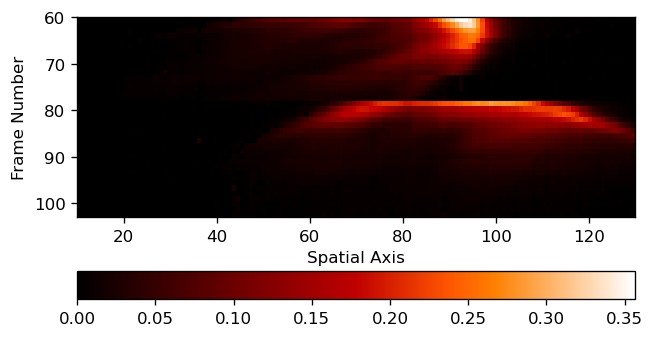

In [305]:
test = np.vstack((h2_a0_map))
test[test>0.5] = 0

plt.imshow(test, extent=[10, len(test[0]), end_kband_north, start_kband_north], cmap='gist_heat')
plt.xlabel('Spatial Axis')
plt.ylabel('Frame Number')
plt.colorbar(orientation='horizontal', pad=0.15)
plt.savefig('h2_a0_map', bbox_inches='tight')

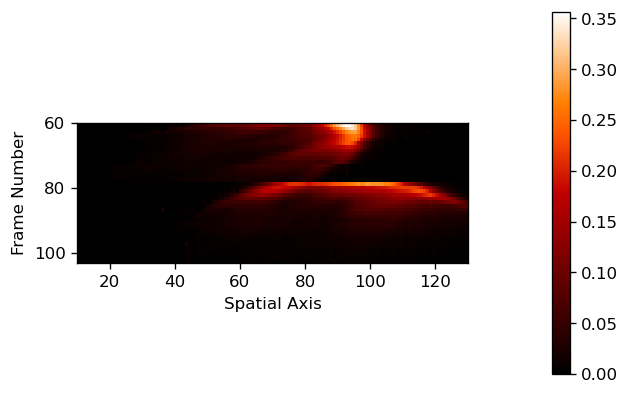

In [309]:
plt.imshow(test, extent=[10, len(test[0]), end_kband_north, start_kband_north], cmap='gist_heat')
plt.xlabel('Spatial Axis')
plt.ylabel('Frame Number')
plt.colorbar(orientation='vertical', pad=0.15)

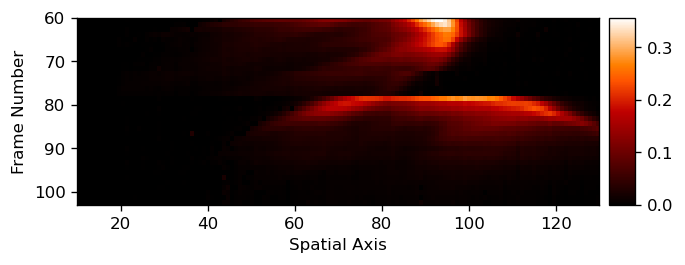

In [314]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np

ax = plt.subplot(111)
im = ax.imshow(test, extent=[10, len(test[0]), end_kband_north, start_kband_north], cmap='gist_heat')
ax.set_xlabel('Spatial Axis')
ax.set_ylabel('Frame Number')

# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.08)

plt.colorbar(im, cax=cax)

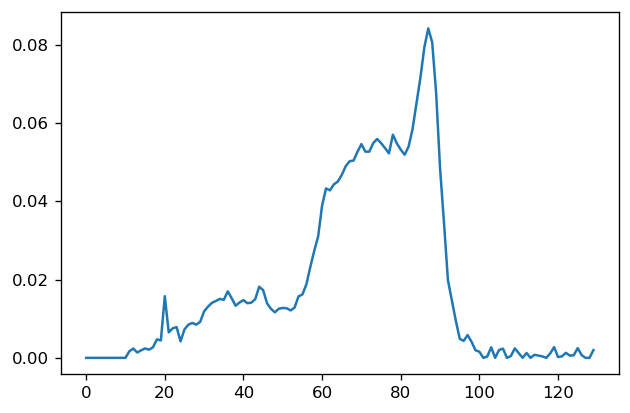

In [289]:
plt.plot(test[10])

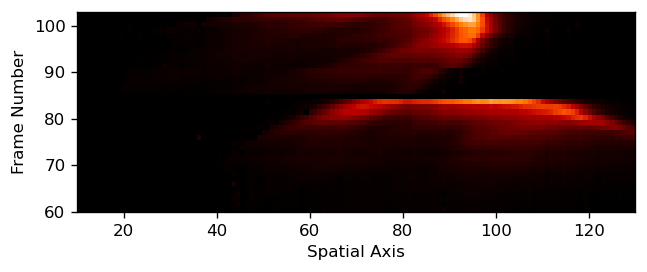

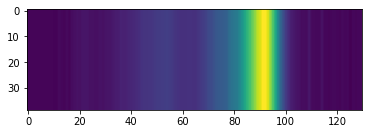

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

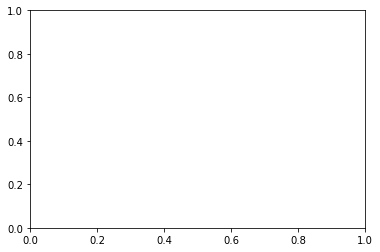

In [156]:
for i in range(len(h2_a0_map)):
    plt.hist2d(i, h2_a0_map[i], cmap=plt.cm.jet)

In [159]:
x = np.random.normal(size=10)
y = x * 3 + np.random.normal(size=10)

np.vstack((x,y))

array([[-1.44380857,  0.02508831,  0.36557786,  1.13806203,  0.55787778,
        -0.57117663,  1.28042627, -0.95368192,  1.17433943, -0.15071844],
       [-2.82746284,  0.49398279,  1.11245613,  4.34051182,  1.10438133,
        -0.26424653,  4.1554031 , -3.00003796,  2.53979396,  0.29681257]])

In [138]:
h2_a0_map[0]

array([0.00000000e+00, 1.89075590e-04, 1.52655413e-03, 0.00000000e+00,
       0.00000000e+00, 6.18546029e-04, 7.65812345e-04, 7.77502204e-04,
       0.00000000e+00, 0.00000000e+00, 1.02795912e-03, 4.92931155e-04,
       1.25519119e-03, 2.61291291e-03, 1.33775457e-03, 1.11297299e-03,
       0.00000000e+00, 0.00000000e+00, 2.33249677e-03, 3.69687894e-03,
       4.76767933e-03, 7.67852158e-03, 1.15232440e-02, 2.24261114e-02,
       3.06142734e-02, 3.73377762e-02, 4.42935087e-02, 5.28184608e-02,
       5.76727277e-02, 6.25297062e-02, 7.12706447e-02, 7.63620683e-02,
       7.90026339e-02, 8.26955417e-02, 8.56539841e-02, 8.57034191e-02,
       8.81689485e-02, 9.16393397e-02, 9.08342506e-02, 9.05030576e-02,
       9.08393020e-02, 9.10664682e-02, 9.32049668e-02, 9.68388608e-02,
       1.01113196e-01, 1.04880791e-01, 1.12379289e-01, 1.20540409e-01,
       1.25130391e-01, 1.25455025e-01, 1.26169385e-01, 1.23183631e-01,
       1.20088920e-01, 1.17880940e-01, 1.09795212e-01, 1.02783978e-01,
      

In [122]:
len(h2_a0_map[0])

123

In [146]:
h2_a0_map

[array([0.00000000e+00, 1.89075590e-04, 1.52655413e-03, 0.00000000e+00,
        0.00000000e+00, 6.18546029e-04, 7.65812345e-04, 7.77502204e-04,
        0.00000000e+00, 0.00000000e+00, 1.02795912e-03, 4.92931155e-04,
        1.25519119e-03, 2.61291291e-03, 1.33775457e-03, 1.11297299e-03,
        0.00000000e+00, 0.00000000e+00, 2.33249677e-03, 3.69687894e-03,
        4.76767933e-03, 7.67852158e-03, 1.15232440e-02, 2.24261114e-02,
        3.06142734e-02, 3.73377762e-02, 4.42935087e-02, 5.28184608e-02,
        5.76727277e-02, 6.25297062e-02, 7.12706447e-02, 7.63620683e-02,
        7.90026339e-02, 8.26955417e-02, 8.56539841e-02, 8.57034191e-02,
        8.81689485e-02, 9.16393397e-02, 9.08342506e-02, 9.05030576e-02,
        9.08393020e-02, 9.10664682e-02, 9.32049668e-02, 9.68388608e-02,
        1.01113196e-01, 1.04880791e-01, 1.12379289e-01, 1.20540409e-01,
        1.25130391e-01, 1.25455025e-01, 1.26169385e-01, 1.23183631e-01,
        1.20088920e-01, 1.17880940e-01, 1.09795212e-01, 1.027839

In [148]:
np.arange(10)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

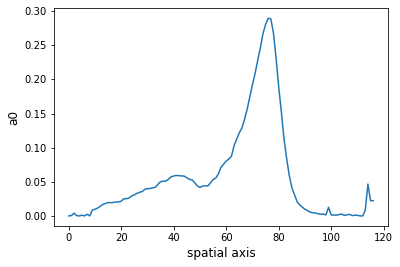

In [113]:
plt.figure()
plt.xlabel('spatial axis', fontsize=12)
plt.ylabel('a0', fontsize=12)
plt.plot(h2_a0_map[2])

TypeError: Image data of dtype object cannot be converted to float

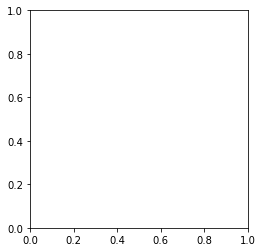

In [131]:
plt.figure()
plt.imshow(h2_a0_map)

In [22]:
np.array(h2_a0_map)

array([array([0.00000000e+00, 0.00000000e+00, 1.25547639e-03, 0.00000000e+00,
       1.89075590e-04, 1.52655413e-03, 0.00000000e+00, 0.00000000e+00,
       6.18546029e-04, 7.65812345e-04, 7.77502204e-04, 0.00000000e+00,
       0.00000000e+00, 1.02795912e-03, 4.92931155e-04, 1.25519119e-03,
       2.61291291e-03, 1.33775457e-03, 1.11297299e-03, 0.00000000e+00,
       0.00000000e+00, 2.33249677e-03, 3.69687894e-03, 4.76767933e-03,
       7.67852158e-03, 1.15232440e-02, 2.24261114e-02, 3.06142734e-02,
       3.73377762e-02, 4.42935087e-02, 5.28184608e-02, 5.76727277e-02,
       6.25297062e-02, 7.12706447e-02, 7.63620683e-02, 7.90026339e-02,
       8.26955417e-02, 8.56539841e-02, 8.57034191e-02, 8.81689485e-02,
       9.16393397e-02, 9.08342506e-02, 9.05030576e-02, 9.08393020e-02,
       9.10664682e-02, 9.32049668e-02, 9.68388608e-02, 1.01113196e-01,
       1.04880791e-01, 1.12379289e-01, 1.20540409e-01, 1.25130391e-01,
       1.25455025e-01, 1.26169385e-01, 1.23183631e-01, 1.20088920e-01,